# Install Labraries and Frameworks

In [6]:
pip install transformers torch


In [49]:
!pip install tqdm

In [2]:
pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_syst

In [8]:
!pip install --upgrade torchvision torchaudio torchtext torch

### Import the labraries

In [3]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from datasets import load_dataset
from tqdm import tqdm
import math
import torch
import matplotlib.pyplot as plt


### Create a model object and tokenizer of gpt-2

In [4]:

model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### Just check the cuda in pytorch for making easy to evaluate

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load the Wikitext-2 dataset

In [6]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [7]:
model.to(device)

print("GPT-2 model loaded successfully!")

GPT-2 model loaded successfully!


### Make set up the model for Evaluation

In [10]:
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

### Define Perplexities Function

In [11]:
def calculate_perplexity(texts):
    """Compute perplexity of GPT-2 on a batch of texts."""
    perplexities = []
    for text in tqdm(texts, desc="Processing"):
        if not text.strip():
            continue

        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        input_ids = inputs.input_ids.to(device)

        if input_ids.numel() == 0:
            continue

        with torch.no_grad():
            outputs = model(input_ids, labels=input_ids)
            loss = outputs.loss

        perplexity = math.exp(loss.item())
        perplexities.append(perplexity)

    return perplexities

### Here takes complete samples for checking perplexity

In [20]:
texts = dataset["text"]

In [21]:
perplexities = calculate_perplexity(texts)


Processing: 100%|██████████| 4358/4358 [00:50<00:00, 87.12it/s] 


In [22]:
for i, ppl in enumerate(perplexities):
    print(f"Sample {i+1}: Perplexity = {ppl:.2f}")


Sample 1: Perplexity = 889.28
Sample 2: Perplexity = 54.88
Sample 3: Perplexity = 43.63
Sample 4: Perplexity = 1335.96
Sample 5: Perplexity = 162.06
Sample 6: Perplexity = 45.32
Sample 7: Perplexity = 56.42
Sample 8: Perplexity = 154.73
Sample 9: Perplexity = 53.97
Sample 10: Perplexity = 47.11
Sample 11: Perplexity = 877.33
Sample 12: Perplexity = 178.09
Sample 13: Perplexity = 183.65
Sample 14: Perplexity = 188.17
Sample 15: Perplexity = 7396.64
Sample 16: Perplexity = 55.47
Sample 17: Perplexity = 38.21
Sample 18: Perplexity = 482.81
Sample 19: Perplexity = 66.80
Sample 20: Perplexity = 164.84
Sample 21: Perplexity = 49.24
Sample 22: Perplexity = 23.54
Sample 23: Perplexity = 85.30
Sample 24: Perplexity = 51.44
Sample 25: Perplexity = 39.46
Sample 26: Perplexity = 64.79
Sample 27: Perplexity = 27.92
Sample 28: Perplexity = 45.51
Sample 29: Perplexity = 173.65
Sample 30: Perplexity = 50.69
Sample 31: Perplexity = 179.72
Sample 32: Perplexity = 37.25
Sample 33: Perplexity = 38.66
Samp

### Average Perplexity

In [23]:
if perplexities:
    avg_perplexity = sum(perplexities) / len(perplexities)
    print(f"\nAverage Perplexity on WikiText-2: {avg_perplexity:.2f}")
else:
    print("No valid text samples found.")


Average Perplexity on WikiText-2: 569.90


### visulaisation result of gpt2

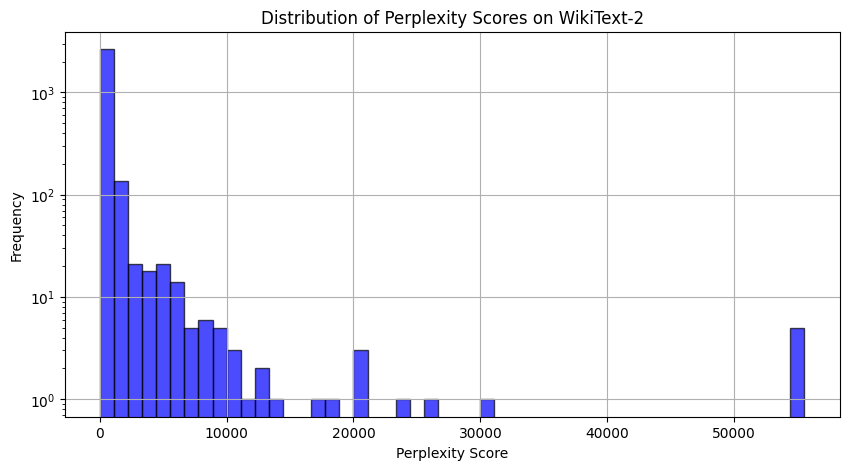

In [24]:
plt.figure(figsize=(10, 5))
plt.hist(perplexities, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Perplexity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Perplexity Scores on WikiText-2")
plt.yscale("log")
plt.grid(True)

# Adversarial Testing:

### Augmentation

In [31]:
import random

def introduce_typos(text, error_rate=0.1):
    text = list(text)
    for i in range(len(text)):
        if random.random() < error_rate:
            text[i] = random.choice("abcdefghijklmnopqrstuvwxyz")
    return "".join(text)

sample_text = "The quick brown fox jumps over the lazy dog."
print("With Typos:", introduce_typos(sample_text))

With Typos: The qugck brtwh fox jumpszcvef the lazycdog.


### Here Creating Modified Dataset-Adding some Typo (Defult 10%)

In [33]:
modified_texts = [introduce_typos(text) for text in dataset["text"]]
dataset = dataset.add_column("modified_text", modified_texts)


In [34]:
modified_text = dataset["modified_text"]
perplexities = calculate_perplexity(modified_text)


Processing: 100%|██████████| 4358/4358 [00:54<00:00, 80.59it/s]


In [35]:
if perplexities:
    avg_perplexity = sum(perplexities) / len(perplexities)
    print(f"\nAverage Perplexity on WikiText-2: {avg_perplexity:.2f}")
else:
    print("No valid text samples found.")


Average Perplexity on WikiText-2: 2205.68


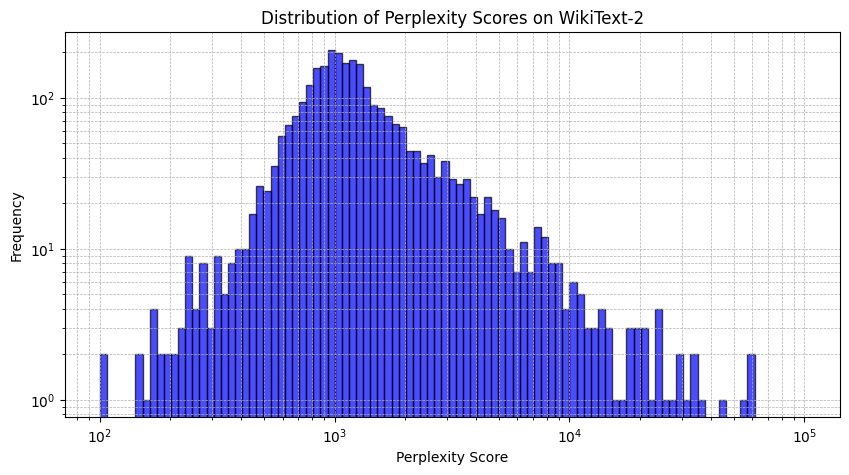

In [44]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.hist(perplexities, bins=np.logspace(2, 5, 100), color='blue', alpha=0.7, edgecolor='black')
plt.xscale("log")
plt.xlabel("Perplexity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Perplexity Scores on WikiText-2")
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()


### Adding Error rate 5% to the dataset

In [46]:
modified_texts = [introduce_typos(text,error_rate=0.05) for text in dataset["text"]]
dataset = dataset.add_column("modified_text_5%Error", modified_texts)

In [47]:
modified_text = dataset["modified_text_5%Error"]
perplexities = calculate_perplexity(modified_text)


Processing: 100%|██████████| 4358/4358 [00:52<00:00, 82.89it/s]


In [48]:
if perplexities:
    avg_perplexity = sum(perplexities) / len(perplexities)
    print(f"\nAverage Perplexity on WikiText-2: {avg_perplexity:.2f}")
else:
    print("No valid text samples found.")


Average Perplexity on WikiText-2: 1241.79


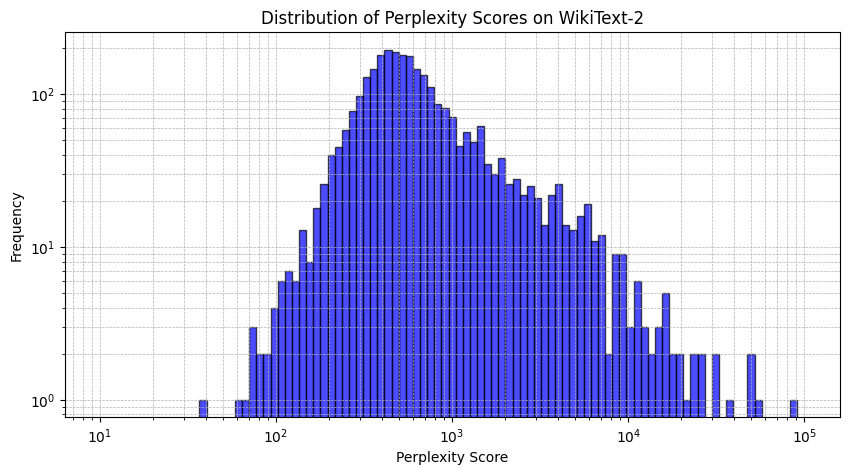

In [52]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.hist(perplexities, bins=np.logspace(1, 5, 100), color='blue', alpha=0.7, edgecolor='black')
plt.xscale("log")
plt.xlabel("Perplexity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Perplexity Scores on WikiText-2")
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()
